In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import sys
!conda install --yes --prefix {sys.prefix} seaborn
import seaborn as sns

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.1.0



## Package Plan ##

  environment location: /usr/local/Caskroom/miniconda/base/envs/my-rdkit-env

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1t             |       hca72f7f_0         3.3 MB
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following packages will be UPDATED:

  openssl                                 1.1.1s-hca72f7f_0 --> 1.1.1t-hca72f7f_0 



                                                                               

In [49]:
df = pd.read_csv(r'path/filename')
print(df)

                                           SMILES   mol MW     SASA     FOSA  \
0                       CNC(=O)[C@@H](CCO)NC(=O)C  174.199  425.510  280.113   
1                    CC(=O)N[C@H](C(=O)NC)c1ccsc1  212.266  459.001  199.537   
2                   CC(=O)N[C@@H](C(=O)NC)c1ccsc1  212.266  462.678  200.276   
3               CC(=O)NC(C1)(C(=O)NC)Cc(c12)cccc2  232.282  501.551  260.464   
4                         CC(=O)NC1(C(=O)NC)CCCC1  184.238  439.701  366.098   
...                                           ...      ...      ...      ...   
3418        CC(=O)N[C@@](C)(C(=O)NC)Cc1cc[nH+]cc1  235.285  485.138  266.405   
3419             CC(=O)N[C@](C)(C(=O)NC)Cc1ccncc1  235.285  482.502  260.659   
3420         CC(=O)N[C@](C)(C(=O)NC)Cc1cc[nH+]cc1  235.285  477.860  263.128   
3421     CC(=O)N[C@H](C(=O)OC)Cc1c[nH]c(c12)cccc2  260.292  512.248  216.188   
3422  CC(=O)N[C@H](C(=O)OC)Cc1c[nH]c(c12)cc(F)cc2  278.282  538.654  224.697   

         FISA     PISA    WPSA  donorHB

In [50]:
descriptors = df.loc[:, ['mol MW', 'SASA', 'FOSA', 'FISA','PISA', 'WPSA','donorHB','accptHB','glob','QPlogPo/w','PSA']].values

In [51]:
descriptors_std = StandardScaler().fit_transform(descriptors)

In [52]:
pca = PCA(n_components = 3)
descriptors_2d = pca.fit_transform(descriptors_std)

In [53]:
descriptors_pca= pd.DataFrame(descriptors_2d)
descriptors_pca.index = df.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(10)

,PC1,PC2,PC3
0,-0.771809,3.300831,-0.327477
1,0.015450,-0.620441,-1.303677
2,0.085703,-0.796966,-1.202368
3,0.274518,-1.507041,0.324911
4,-2.394510,-0.082153,0.418254
5,-2.563723,0.476949,-1.334367
6,-2.489201,0.415029,-1.194920
7,-2.488938,0.414998,-1.194249
8,-2.563722,0.476949,-1.334366
9,-1.094856,-1.279416,-1.724084


In [54]:
print(pca.explained_variance_ratio_) 
print(sum(pca.explained_variance_ratio_))

[0.33770789 0.30170541 0.11910954]
0.7585228390378542


<Figure size 800x600 with 0 Axes>

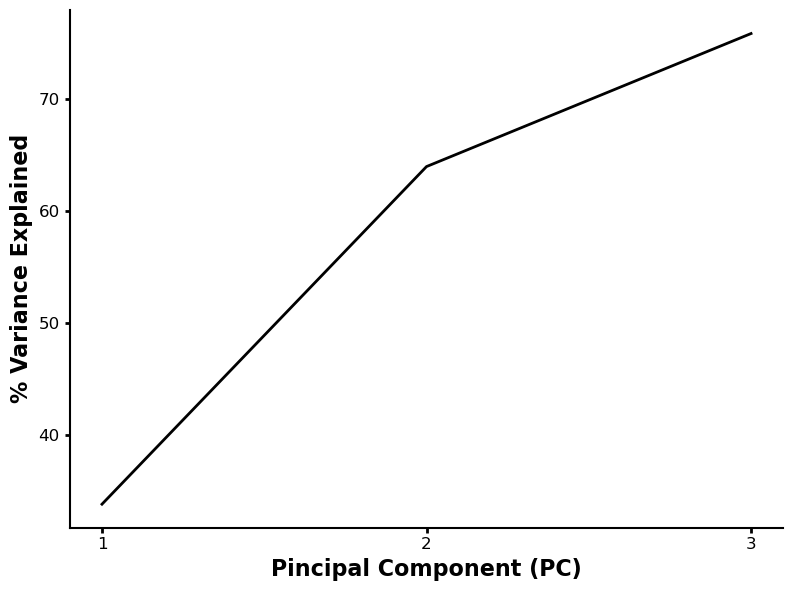

In [55]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.plot([i+1 for i in range(len(var))],var,'k-',linewidth=2)
plt.xticks([i+1 for i in range(len(var))])
plt.ylabel('% Variance Explained',fontsize=16,fontweight='bold')
plt.xlabel('Pincipal Component (PC)',fontsize=16,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=12)

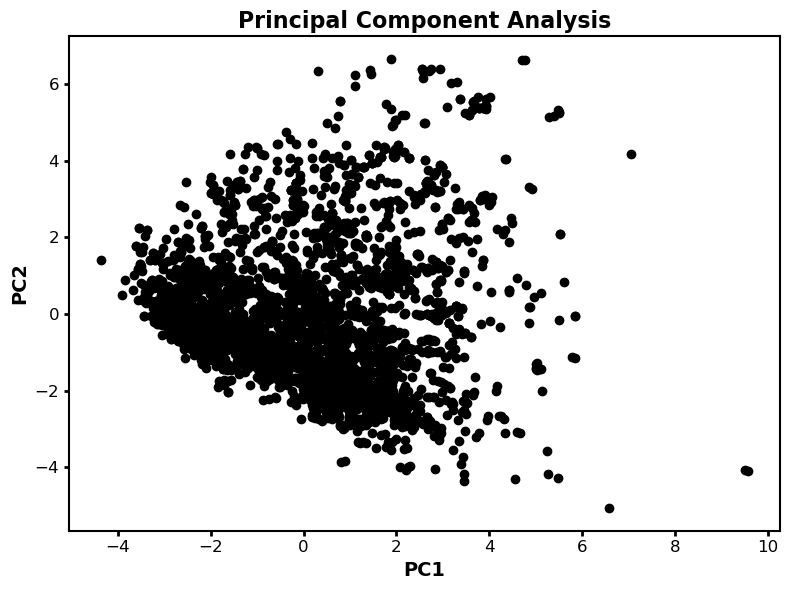

In [56]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(descriptors_pca['PC1'],descriptors_pca['PC2'],'o',color='k')
ax.set_title ('Principal Component Analysis',fontsize=16,fontweight='bold',family='sans-serif')
ax.set_xlabel ('PC1',fontsize=14,fontweight='bold')
ax.set_ylabel ('PC2',fontsize=14,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=12)

plt.tight_layout()
plt.show()

In [57]:
scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1']))
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))
scale3 = 1.0/(max(descriptors_pca['PC3']) - min(descriptors_pca['PC3']))
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]
descriptors_pca['PC3_normalized']=[i*scale3 for i in descriptors_pca['PC3']]

In [58]:
descriptors_pca.head(10)

,PC1,PC2,PC3,PC1_normalized,PC2_normalized,PC3_normalized
0,-0.771809,3.300831,-0.327477,-0.055431,0.281665,-0.041886
1,0.015450,-0.620441,-1.303677,0.001110,-0.052943,-0.166746
2,0.085703,-0.796966,-1.202368,0.006155,-0.068006,-0.153788
3,0.274518,-1.507041,0.324911,0.019716,-0.128598,0.041558
4,-2.394510,-0.082153,0.418254,-0.171973,-0.007010,0.053496
5,-2.563723,0.476949,-1.334367,-0.184126,0.040699,-0.170671
6,-2.489201,0.415029,-1.194920,-0.178774,0.035415,-0.152835
7,-2.488938,0.414998,-1.194249,-0.178755,0.035412,-0.152749
8,-2.563722,0.476949,-1.334366,-0.184126,0.040699,-0.170671
9,-1.094856,-1.279416,-1.724084,-0.078632,-0.109174,-0.220518


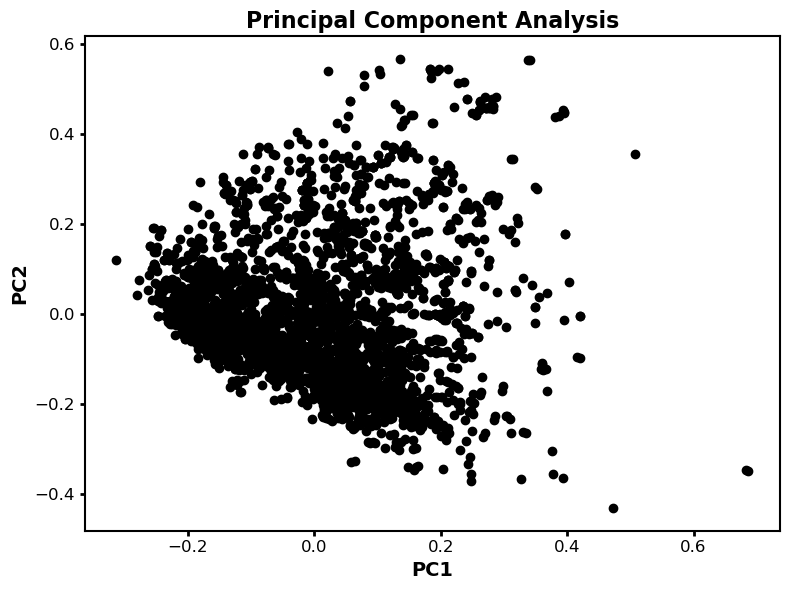

In [59]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(descriptors_pca['PC1_normalized'],descriptors_pca['PC2_normalized'],'o',color='k')
ax.set_title ('Principal Component Analysis',fontsize=16,fontweight='bold',family='sans-serif')
ax.set_xlabel ('PC1',fontsize=14,fontweight='bold')
ax.set_ylabel ('PC2',fontsize=14,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=12)

plt.tight_layout()
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4410421718798591
For n_clusters = 3 The average silhouette_score is : 0.4562095653852503
For n_clusters = 4 The average silhouette_score is : 0.44330201548843123
For n_clusters = 5 The average silhouette_score is : 0.3732514598120962
For n_clusters = 6 The average silhouette_score is : 0.3919702474248664
For n_clusters = 7 The average silhouette_score is : 0.35892212282294733
For n_clusters = 8 The average silhouette_score is : 0.3652709876916228
For n_clusters = 9 The average silhouette_score is : 0.3469811885008259
For n_clusters = 10 The average silhouette_score is : 0.354194487141344


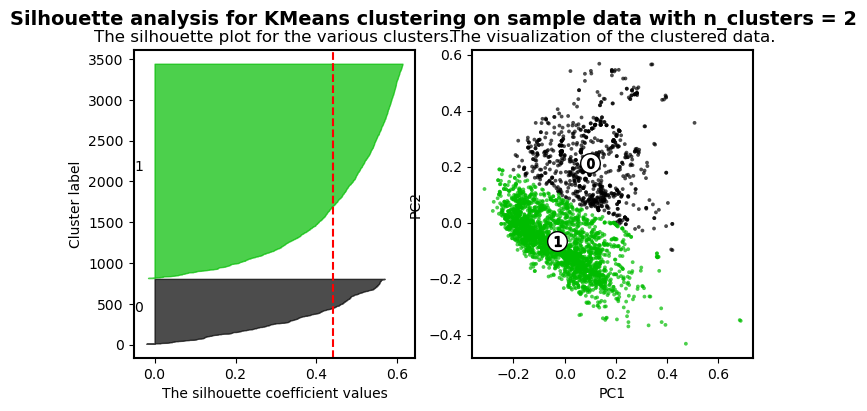

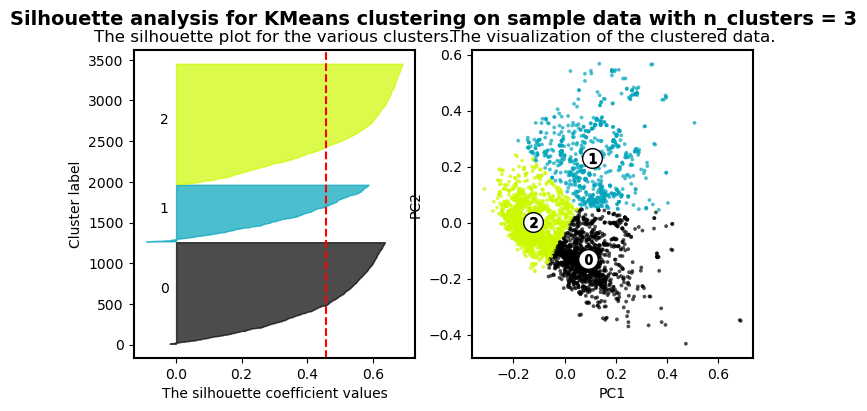

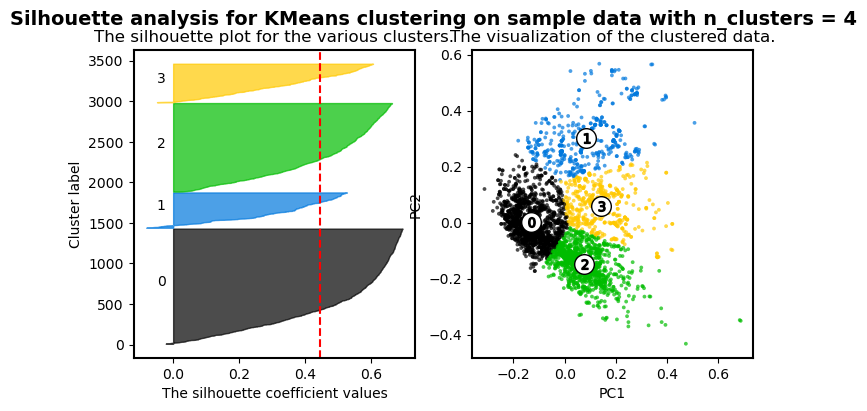

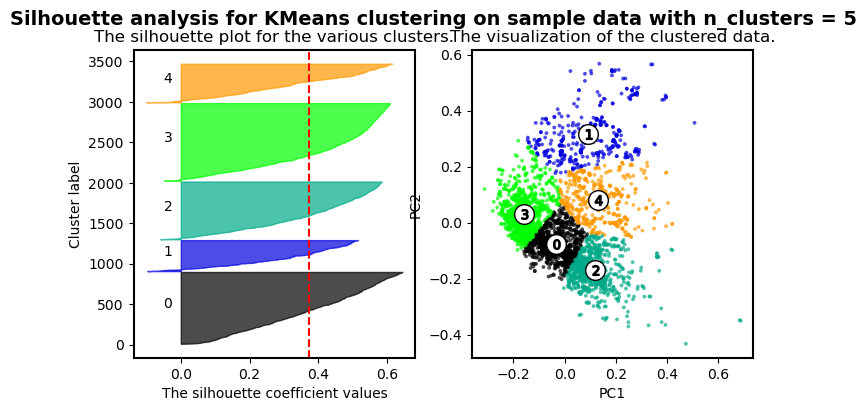

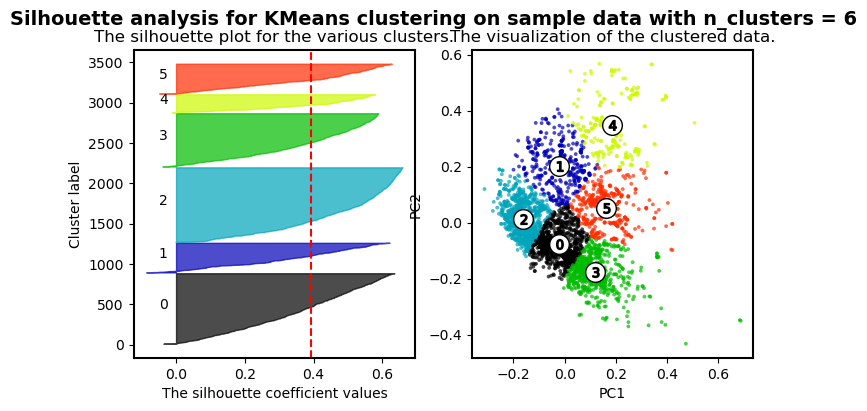

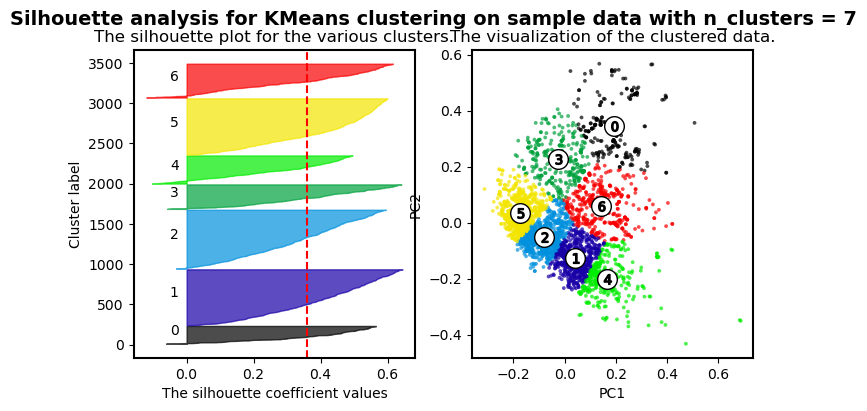

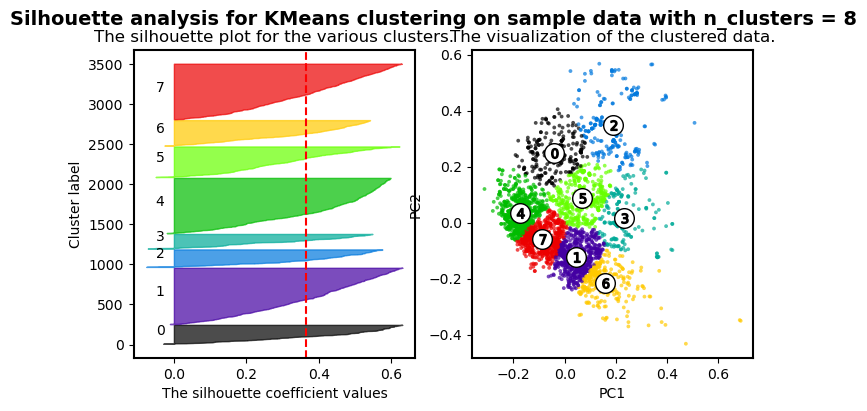

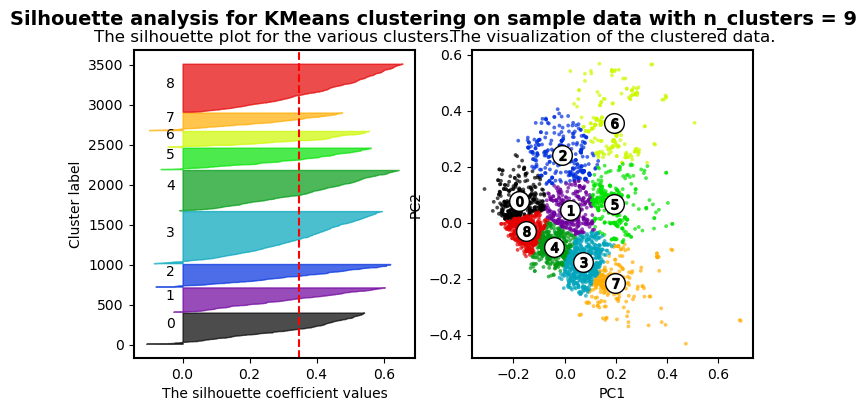

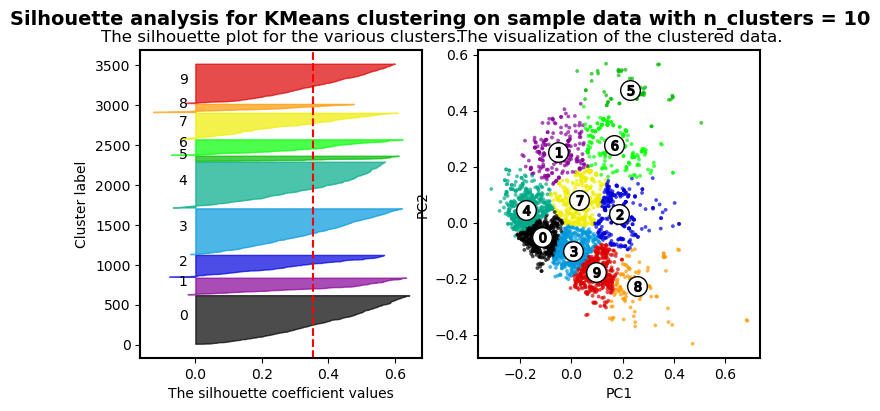

In [60]:
range_n_clusters = [2, 3, 4, 5, 6, 7,8,9,10]
for n_clusters in range_n_clusters:
    fig, (ax1,ax2)= plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized','PC2_normalized']])
    silhouette_avg = silhouette_score(descriptors_pca[['PC1_normalized','PC2_normalized']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(descriptors_pca[['PC1_normalized','PC2_normalized']], cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'], 
                marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')


    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    
plt.show()

In [61]:
kmeans = KMeans(n_clusters=8, random_state=10)
clusters = kmeans.fit(descriptors_pca[['PC1_normalized','PC2_normalized']])

In [62]:
descriptors_pca['Cluster_PC1_PC2'] = pd.Series(clusters.labels_, index=df.index)

In [63]:
descriptors_pca.head(10)

,PC1,PC2,PC3,PC1_normalized,PC2_normalized,PC3_normalized,Cluster_PC1_PC2
0,-0.771809,3.300831,-0.327477,-0.055431,0.281665,-0.041886,0
1,0.015450,-0.620441,-1.303677,0.001110,-0.052943,-0.166746,1
2,0.085703,-0.796966,-1.202368,0.006155,-0.068006,-0.153788,1
3,0.274518,-1.507041,0.324911,0.019716,-0.128598,0.041558,1
4,-2.394510,-0.082153,0.418254,-0.171973,-0.007010,0.053496,4
5,-2.563723,0.476949,-1.334367,-0.184126,0.040699,-0.170671,4
6,-2.489201,0.415029,-1.194920,-0.178774,0.035415,-0.152835,4
7,-2.488938,0.414998,-1.194249,-0.178755,0.035412,-0.152749,4
8,-2.563722,0.476949,-1.334366,-0.184126,0.040699,-0.170671,4
9,-1.094856,-1.279416,-1.724084,-0.078632,-0.109174,-0.220518,7


<Figure size 1000x800 with 0 Axes>

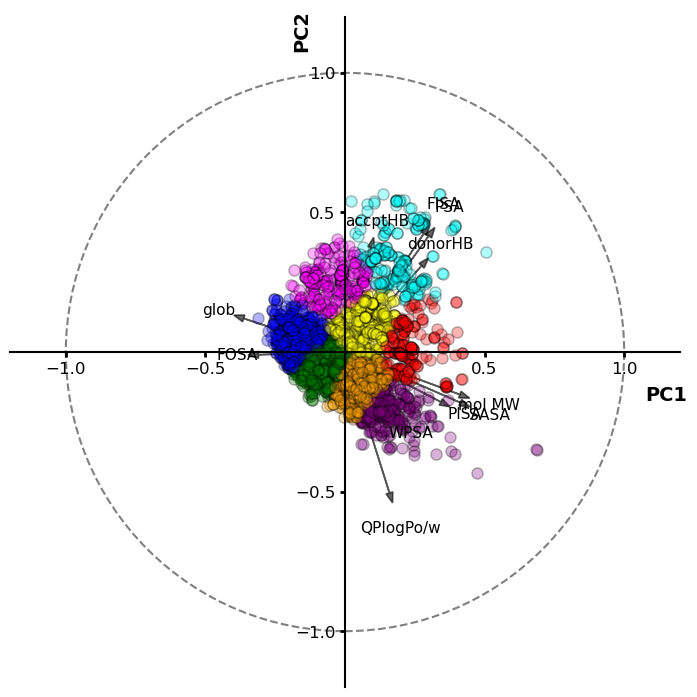

In [64]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(10,8))

fig, ax = plt.subplots(figsize=(7,7))

color_code={ 0:        'magenta',\
             1.0:   'orange',\
             2.0:      'cyan',\
             3.0:           'red',\
             4.0:        'blue',\
             5.0:        'yellow',\
             6.0:        'purple',\
             7.0:       'green',\
             8.0:       'pink',\
             9.0:       'dark',\
           }

for i in descriptors_pca.index: 
        ax.plot(descriptors_pca.loc[i].at['PC1_normalized'],descriptors_pca.loc[i].at['PC2_normalized'],
                    c=color_code[descriptors_pca.loc[i].at['Cluster_PC1_PC2']],
                    marker='o',markersize=8,markeredgecolor='k',alpha=0.3)
        

plt.xlabel ('PC1',fontsize=14,fontweight='bold')
ax.xaxis.set_label_coords(0.98, 0.45)
plt.ylabel ('PC2',fontsize=14,fontweight='bold')
ax.yaxis.set_label_coords(0.45, 0.98)
plt.tick_params ('both',width=2,labelsize=12)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

lab=['mol MW', 'SASA', 'FOSA', 'FISA','PISA', 'WPSA','donorHB','accptHB','glob','QPlogPo/w','PSA'] 

l=np.transpose(pca.components_[0:2, :]) 

n = l.shape[0]
for i in range(n):
    plt.arrow(0, 0, l[i,0], l[i,1],color= 'k',alpha=0.6,linewidth=1.2,head_width=0.025)
    plt.text(l[i,0]*1.25, l[i,1]*1.25, lab[i], color = 'k',va = 'center', ha = 'center',fontsize=11)

circle = plt.Circle((0,0), 1, color='gray', fill=False,clip_on=True,linewidth=1.5,linestyle='--')
ax.add_artist(circle)
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.tight_layout()
plt.show()


In [65]:
table=df.join(descriptors_pca)

In [66]:
table.head()

,SMILES,mol MW,SASA,FOSA,FISA,PISA,WPSA,donorHB,accptHB,glob,QPlogPo/w,PSA,PC1,PC2,PC3,PC1_normalized,PC2_normalized,PC3_normalized,Cluster_PC1_PC2
0,CNC(=O)[C@@H](CCO)NC(=O)C,174.199,425.510,280.113,145.397,0.000,0.000,2.25,5.95,0.869831,-1.236,97.343,-0.771809,3.300831,-0.327477,-0.055431,0.281665,-0.041886,0
1,CC(=O)N[C@H](C(=O)NC)c1ccsc1,212.266,459.001,199.537,96.059,107.476,55.930,1.25,4.25,0.859979,0.544,76.267,0.015450,-0.620441,-1.303677,0.001110,-0.052943,-0.166746,1
2,CC(=O)N[C@@H](C(=O)NC)c1ccsc1,212.266,462.678,200.276,91.600,114.869,55.932,1.25,4.25,0.855497,0.599,74.386,0.085703,-0.796966,-1.202368,0.006155,-0.068006,-0.153788,1
3,CC(=O)NC(C1)(C(=O)NC)Cc(c12)cccc2,232.282,501.551,260.464,73.002,168.085,0.000,1.25,4.25,0.851510,1.125,68.695,0.274518,-1.507041,0.324911,0.019716,-0.128598,0.041558,1
4,CC(=O)NC1(C(=O)NC)CCCC1,184.238,439.701,366.098,73.603,0.000,0.000,1.25,4.25,0.875047,0.199,69.253,-2.394510,-0.082153,0.418254,-0.171973,-0.007010,0.053496,4


In [67]:
table.to_csv('path/filename')